### Initialize

In [1]:
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pygini
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from adjustText import adjust_text
from scipy.sparse import coo_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader

random.seed(42)
torch.manual_seed(42)
torch.mps.manual_seed(42)

In [2]:
chr_index = pd.read_csv("index.csv", header=0)
pos_coord_egfr = np.where(chr_index["loc"] == "chr7_55000000")[0][0]
pos_coord_myc = np.where(chr_index["loc"] == "chr8_127000000")[0][0]

window_0 = 7
window_1 = 7

chr_size = [249, 243, 199, 191, 182, 171, 160, 146, 139, 134, 136, 134, 115, 108, 102, 91, 84, 81, 59, 65, 47, 51, 157]

In [3]:
def read_mtx(path, index):
    contact_mat = pd.read_csv(path, sep="\t", header=0)
    contact_mat = contact_mat[(contact_mat["chrom1"] != "chrY") & (contact_mat["chrom2"] != "chrY")]
    contact_mat = pd.concat([contact_mat["chrom1"] + "_" + contact_mat["start1"].astype(str),
                             contact_mat["chrom2"] + "_" + contact_mat["start2"].astype(str), contact_mat["count"]],
                            axis=1)
    contact_mat.columns = ["loc1", "loc2", "count"]
    contact_mat = pd.merge(contact_mat, index, left_on="loc1", right_on="loc", how="left").drop(["loc", "loc1"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index1"})
    contact_mat = pd.merge(contact_mat, index, left_on="loc2", right_on="loc", how="left").drop(["loc", "loc2"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index2"})
    contact_mat = coo_matrix((contact_mat['count'], (contact_mat['index1'], contact_mat['index2'])),
                             shape=(index.shape[0], index.shape[0]))
    contact_mat = contact_mat.toarray()

    return contact_mat

In [4]:
def prep_data(sample, coord, index, is_pos, win0, offset):
    matrices_f2 = []
    bcs = []

    directories = sorted(
        [d for d in os.listdir("data/raw/" + sample) if os.path.isdir(os.path.join("data/raw/" + sample, d))])
    for directory in directories:

        if not os.path.exists("data/raw/" + sample + "/" + directory + "/1000000.CNV.bedGraph"):
            continue

        try:
            mtx = read_mtx("data/raw/" + sample + "/" + directory + "/matrix.mtx", index)
        except:
            continue

        for off in range(-offset, offset + 1):
            stacked_mtx_f2 = torch.from_numpy(
                mtx[(coord + off - int((win0 + 1) / 2) + 1):(coord + off + int((win0 + 1) / 2)), :]).to_sparse_coo()
            matrices_f2.append(stacked_mtx_f2)
            bcs = bcs + [directory]

    input = torch.stack(matrices_f2, dim=0)

    if is_pos:
        label = torch.from_numpy(np.ones(input.shape[0])).int()
    else:
        label = torch.from_numpy(np.zeros(input.shape[0])).int()

    return input, label, bcs

### Prepare data

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC499", pos_coord_egfr, chr_index, True, window_0, 1)
neg_data, neg_label, neg_bcs = prep_data("LC500", pos_coord_egfr, chr_index, False, window_0, 1)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [ ]:
torch.save(input_all, "data/processed/input_499500_win7off1.npy")
torch.save(label, "data/processed/label_499500_win7off1.npy")
torch.save(barcode, "data/processed/barcode_499500_win7off1.npy")

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC676", pos_coord_myc, chr_index, True, window_0, 1)
neg_data, neg_label, neg_bcs = prep_data("LC677", pos_coord_myc, chr_index, False, window_0, 1)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [8]:
torch.save(input_all, "data/processed/input_676677_win7off1.npy")
torch.save(label, "data/processed/label_676677_win7off1.npy")
torch.save(barcode, "data/processed/barcode_676677_win7off1.npy")

### Define model

In [5]:
input_499500 = torch.load("data/processed/input_499500_win7off0.npy").to_dense()
label_499500 = torch.load("data/processed/label_499500_win7off0.npy")
barcode_499500 = torch.load("data/processed/barcode_499500_win7off0.npy")

input_676677 = torch.load("data/processed/input_676677_win7off0.npy").to_dense()
label_676677 = torch.load("data/processed/label_676677_win7off0.npy")
barcode_676677 = torch.load("data/processed/barcode_676677_win7off0.npy")

In [6]:
coordinate_499500 = np.repeat(pos_coord_egfr, input_499500.shape[0]).tolist()
coordinate_676677 = np.repeat(pos_coord_myc, input_676677.shape[0]).tolist()

In [7]:
label_676677 = torch.where(label_676677 == 0, 2, label_676677)  # Mark HSR samples as 2

In [8]:
barcode = barcode_499500 + barcode_676677
coordinate = coordinate_499500 + coordinate_676677

#input_all = input_499500
#label = label_499500

input_all = torch.cat((input_499500, input_676677), dim=0)
label = torch.cat((label_499500, label_676677), dim=0)

In [9]:
validation_bcs_499500 = pd.read_table("data/processed/barcode_val_499500.txt", header=None).iloc[:, 0].tolist()
validation_bcs_676677 = pd.read_table("data/processed/barcode_val_676677.txt", header=None).iloc[:, 0].tolist()
validation_bcs = validation_bcs_499500 + validation_bcs_676677

validation_indices = torch.tensor([i for i in range(len(barcode)) if barcode[i] in validation_bcs])
training_indices = torch.tensor([i for i in range(len(barcode)) if barcode[i] not in validation_bcs])

In [10]:
input_train = torch.index_select(input_all, 0, training_indices)
label_train = torch.index_select(label, 0, training_indices)
barcode_train = [barcode[i] for i in training_indices]
coordinate_train = [coordinate[i] for i in training_indices]

input_val = torch.index_select(input_all, 0, validation_indices)
label_val = torch.index_select(label, 0, validation_indices)
barcode_val = [barcode[i] for i in validation_indices]
coordinate_val = [coordinate[i] for i in validation_indices]

In [11]:
class QuadDataset(Dataset):
    def __init__(self, input, label, barcode, coord):
        self.input = input
        self.label = label
        self.barcode = barcode
        self.coord = coord

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_s = self.input[index]
        bc_s = self.barcode[index]
        coord_s = self.coord[index]

        label_s = torch.eye(3)[self.label[index].detach().numpy()]  # Negative, ecDNA, HSR

        return input_s, label_s, bc_s, coord_s

In [12]:
batch_size = 32

train_dataloader = DataLoader(QuadDataset(input_train, label_train, barcode_train, coordinate_train),
                              batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(QuadDataset(input_val, label_val, barcode_val, coordinate_val), batch_size=batch_size,
                            shuffle=False)
#test_dataloader1 = DataLoader(QuadDataset(input_676677, label_676677, barcode_676677, coordinate_676677), batch_size=batch_size, shuffle=False)
#test_dataloader2 = DataLoader(QuadDataset(input_729730, label_729730, barcode_729730, coordinate_729730), batch_size=batch_size, shuffle=False)

In [13]:
def zi_pois_noise(shape, lambda_, p_zero):
    uniform_noise = torch.rand(shape)

    zero_mask = uniform_noise < p_zero

    poisson_noise = torch.poisson(lambda_ * torch.ones(shape))

    noise = poisson_noise * ~zero_mask

    return noise

In [14]:
class BootCELoss(nn.Module):
    def __init__(self, alpha, bootstrap_type, weight):
        super(BootCELoss, self).__init__()
        self.alpha = alpha
        self.bootstrap_type = bootstrap_type
        self.weight = weight

    def forward(self, prediction_tensor, target_tensor):
        if self.bootstrap_type == 'soft':
            bootstrap_target_tensor = self.alpha * target_tensor + (1.0 - self.alpha) * prediction_tensor

        elif self.bootstrap_type == 'hard':
            max_index = torch.argmax(prediction_tensor, dim=1)
            prediction_tensor_binary = torch.zeros_like(prediction_tensor)
            prediction_tensor_binary[max_index] = 1

            bootstrap_target_tensor = self.alpha * target_tensor + (1.0 - self.alpha) * (
                prediction_tensor_binary).float()
        else:
            raise ValueError('Not a valid value of bootstrap_type')

        per_entry_cross_ent = F.cross_entropy(input=prediction_tensor,
                                              target=bootstrap_target_tensor, reduction='mean',
                                              weight=torch.Tensor(self.weight).to("mps"))

        return per_entry_cross_ent

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_f2_l1 = nn.Conv2d(1, 8, kernel_size=(7, 45), stride=(1, 11), padding=(0, 2))
        self.conv_f2_l2 = nn.Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4), padding=(0, 0))

        self.bn_f2_l1 = nn.BatchNorm2d(8)
        self.bn_f2_l2 = nn.BatchNorm2d(16)

        self.bn_fc_l1 = nn.BatchNorm1d(64)

        self.pool_f2_l1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.pool_f2_l2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)

        self.fc_l1 = nn.Linear(7 * 7 + 12 * 16 + 7 +1, 64)
        self.fc_l2 = nn.Linear(64, 3)

        self.dropout_f2 = nn.Dropout(0.5)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.softmax = nn.Softmax(dim=1)
        
        self.fc_chr1 = nn.Linear(23, 32)
        self.fc_chr2 = nn.Linear(32, 8)

    def forward(self, x2, coord):

        #if self.training:
        #    noise = zi_pois_noise(x2.shape, 1, 0.9999)
        #    x2 = x2 + noise.float().to("mps")

        start_indices = coord - int((7 + 1) / 2) + 1
        end_indices = coord + int((7 + 1) / 2)
        
        x2_chr = torch.split(x2[...,3,:], chr_size, dim=-1)
        x2_chr = torch.stack([torch.squeeze(torch.sum(st, dim=-1), dim=-1) for st in x2_chr], dim=-1)
        
        gini = []
        for i in range(x2_chr.shape[0]):
            gini.append(torch.tensor(pygini.gini(x2_chr[i, :].cpu().numpy()), dtype=torch.float32))
            
        gini = torch.unsqueeze(torch.stack(gini, dim=0).to("mps"), dim=-1)   
        
        #ginis = []
        
        #for j in range(window_0):
        #    x2_chr = torch.split(x2[..., j, :], chr_size, dim=-1)
        #    x2_chr = torch.stack([torch.squeeze(torch.sum(st, dim=-1), dim=-1) for st in x2_chr], dim=-1)

        #    gini = []
        #    for i in range(x2_chr.shape[0]):
        #        gini.append(torch.tensor(pygini.gini(x2_chr[i, :].cpu().numpy()), dtype=torch.float32))

        #    gini = torch.unsqueeze(torch.stack(gini, dim=0), dim=-1)
        
        #    ginis.append(gini)
            
        #ginis = torch.cat(ginis, dim=-1).to("mps")

        d4_slices = []

        for i in range(x2.size(0)):
            d4_slices.append(x2[i, ..., start_indices[i]:end_indices[i]])

        x1 = torch.stack(d4_slices, dim=0)
        
        x1 = (x1 > 0).float()
        x2 = (x2 > 0).float()

        x2_s = F.normalize(torch.squeeze(torch.sum(x2, dim=-1), dim=1), dim=-1, p=1)

        x2 = self.pool_f2_l1(F.relu(self.bn_f2_l1(self.conv_f2_l1(x2))))
        x2 = self.dropout_f2(x2)
        x2 = self.pool_f2_l2(F.relu(self.bn_f2_l2(self.conv_f2_l2(x2))))
        x2 = x2.view(-1, 12 * 16)
        
        x1 = x1.view(-1, 7 * 7)

        x = torch.cat((x1, x2, x2_s, gini), dim=1)
        x = self.dropout_fc(F.gelu(self.bn_fc_l1(self.fc_l1(x))))
        x = self.softmax(self.fc_l2(x))

        return x

In [16]:
model = CNN().to("mps")

criterion = BootCELoss(alpha=0.9, bootstrap_type="hard", weight=[2.02,2.68/20,7.66/100]).to("mps")
#criterion = nn.CrossEntropyLoss(weight=torch.Tensor([2.02, 2.68 / 20, 7.66 / 100]).to("mps"))

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.125)

train_losses_epoch = []
val_losses_epoch = []

accuracies_epoch = []
precision_epoch = []
sensitivity_epoch = []
specificity_epoch = []
f1_epoch = []

epochs = []

num_epochs = 16

### Train model

In [17]:
for epoch in range(num_epochs):
    
    #if epoch >= 16:
    #    scheduler.step()

    losses = []
    sizes = []

    model.train()
    for x2, y0, _, coord in train_dataloader:
        x2 = x2.float().to("mps")
        y0 = y0.float().to("mps")

        optimizer.zero_grad()
        yh = model(x2, coord)

        loss = criterion(yh, y0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        sizes.append(len(y0))

    train_loss = np.average(losses, weights=sizes)

    losses = []
    sizes = []

    val_labels = []
    val_predictions = []
    val_directories = []

    model.eval()
    with torch.no_grad():
        for x2, y0, bcs, coord in val_dataloader:
            x2 = x2.float().to("mps")
            y0 = y0.float().to("mps")

            yh = model(x2, coord)

            loss = criterion(yh, y0)

            yp_am = torch.argmax(yh, dim=1).to("cpu").numpy().tolist()
            y0_am = torch.argmax(y0, dim=1).to("cpu").numpy().tolist()

            losses.append(loss.item())
            sizes.append(len(y0))

            val_labels = val_labels + y0_am
            val_predictions = val_predictions + yp_am
            val_directories = val_directories + list(bcs)

        pred_summary = pd.DataFrame(
            {"label": val_labels, "prediction": val_predictions, "barcode": val_directories})
        pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

        conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
        tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

        accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
        precision = precision_score(pred_summary["label"], pred_summary["prediction"], average="micro")
        recall = recall_score(pred_summary["label"], pred_summary["prediction"], average="micro")
        f1 = f1_score(pred_summary["label"], pred_summary["prediction"], average="micro")
        specificity = tn / (tn + fp)

        val_loss = np.average(losses, weights=sizes)

    train_losses_epoch.append(train_loss)
    val_losses_epoch.append(val_loss)
    accuracies_epoch.append(accuracy)
    precision_epoch.append(precision)
    sensitivity_epoch.append(recall)
    specificity_epoch.append(specificity)
    f1_epoch.append(f1)

    epochs.append(epoch + 1)

    print(
        f'epoch {epoch + 1}/{num_epochs}, train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_accu: {accuracy:.4f}, val_prec: {precision:.4f}, val_sens: {recall:.4f}, val_spec: {specificity:.4f}, val_f1: {f1:.4f}, log10lr: {np.log10(optimizer.param_groups[0]["lr"]):.4f}')

    #scheduler.step(val_loss)

epoch 1/16, train_loss: 0.5937, val_loss: 0.5539, val_accu: 0.7545, val_prec: 0.7545, val_sens: 0.7545, val_spec: 0.9964, val_f1: 0.7545, log10lr: -3.0000
epoch 2/16, train_loss: 0.5672, val_loss: 0.5497, val_accu: 0.7964, val_prec: 0.7964, val_sens: 0.7964, val_spec: 0.9964, val_f1: 0.7964, log10lr: -3.0000
epoch 3/16, train_loss: 0.5658, val_loss: 0.5472, val_accu: 0.8494, val_prec: 0.8494, val_sens: 0.8494, val_spec: 0.9964, val_f1: 0.8494, log10lr: -3.0000
epoch 4/16, train_loss: 0.5649, val_loss: 0.5449, val_accu: 0.8794, val_prec: 0.8794, val_sens: 0.8794, val_spec: 0.9947, val_f1: 0.8794, log10lr: -3.0000
epoch 5/16, train_loss: 0.5632, val_loss: 0.5441, val_accu: 0.8691, val_prec: 0.8691, val_sens: 0.8691, val_spec: 0.9964, val_f1: 0.8691, log10lr: -3.0000
epoch 6/16, train_loss: 0.5632, val_loss: 0.5440, val_accu: 0.8734, val_prec: 0.8734, val_sens: 0.8734, val_spec: 0.9964, val_f1: 0.8734, log10lr: -3.0000
epoch 7/16, train_loss: 0.5613, val_loss: 0.5416, val_accu: 0.9110, va

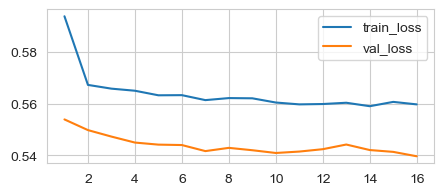

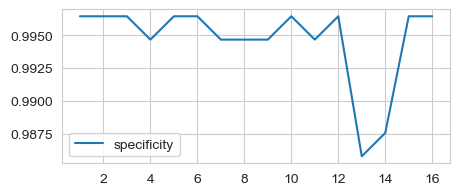

In [18]:
plt.figure(figsize=(5, 2))
plt.plot(epochs, train_losses_epoch, label='train_loss')
plt.plot(epochs, val_losses_epoch, label='val_loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(epochs, specificity_epoch, label='specificity')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(pd.DataFrame(conf_matrix))

     0    1    2
0  561    2    0
1   77  359    5
2    2   10  153


In [20]:
pred_summary[pred_summary["correct"] == False]

,label,prediction,barcode,correct
2,1,0,LC499_AAAGGGCCAAATGCTC,False
4,1,0,LC499_AACAAAGTCCATGACA,False
15,1,0,LC499_ACAAAGAAGGATGTAT,False
20,1,0,LC499_ACAGGCCAGCATTGGG,False
22,1,0,LC499_ACCCAAACACGTACAT,False
...,...,...,...,...
1138,2,1,LC677_merged_hg38.sc_TCACAAGGTTCTCGAA,False
1140,2,1,LC677_merged_hg38.sc_TCCGACTAGGTAAGTT,False
1141,2,1,LC677_merged_hg38.sc_TCGATTTGTTCACGTA,False
1146,2,1,LC677_merged_hg38.sc_TGCGTAACAACGGGTA,False


### Test model

In [21]:
def slide(matrix, window_0, window_1):
    half_window_0 = int((window_0 - 1) / 2)
    half_window_1 = int((window_1 - 1) / 2)

    centers = []
    tensors = []

    for i in range(matrix.shape[0] - window_1 + 1):
        center = i + half_window_1
        lower = center - half_window_0
        upper = center + half_window_0 + 1

        tensors.append(matrix[lower:upper, :])
        centers.append(center)

    test_tensor = torch.stack(tensors, dim=0)
    centers = np.array(centers)

    return test_tensor, centers

In [22]:
matrix_test = read_mtx("data/raw/LC729/LC729_ACCGCAGGTACAACGG/matrix.mtx", chr_index)
test_tensor, centers = slide(torch.from_numpy(matrix_test), window_0, window_1)

model.eval()
with torch.no_grad():
    test_tensor = test_tensor.unsqueeze(1).float().to("mps")

    test_pred = torch.argmax(model(test_tensor, centers), dim=1).to("cpu").numpy()

test_predictions = pd.DataFrame({"coord": centers, "prediction": test_pred})

test_predictions = pd.merge(test_predictions, chr_index, left_on="coord", right_on="index", how="left").drop("index",
                                                                                                             axis=1)

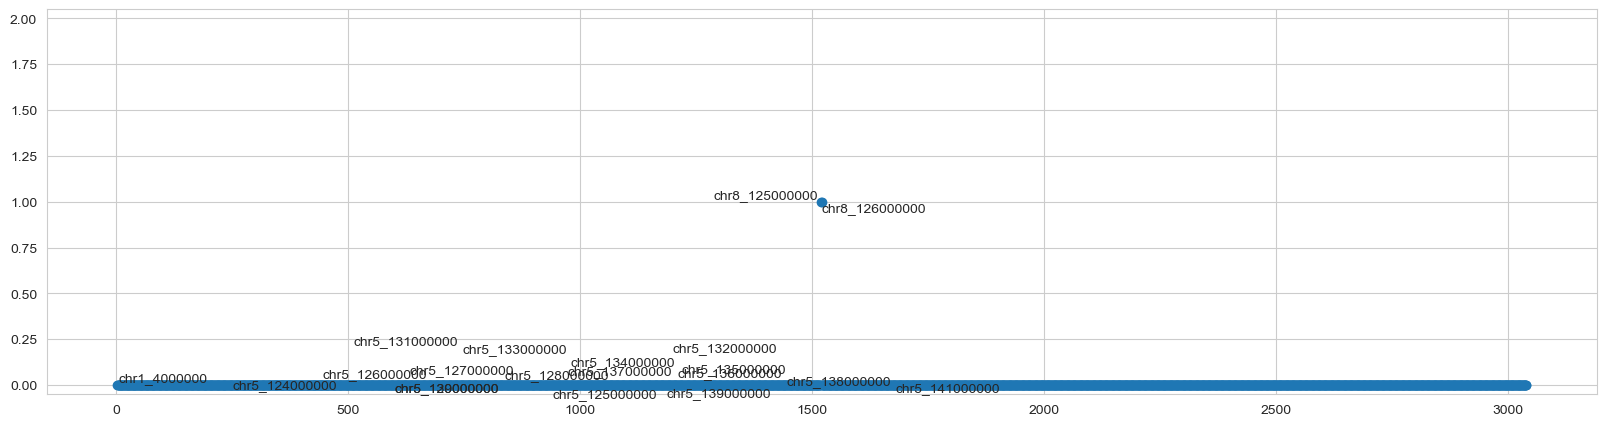

In [23]:
plt.figure(figsize=(20, 5))

plt.scatter(test_predictions['coord'], test_predictions['prediction'])

top_indices = test_predictions['prediction'].argsort()[-20:]

texts = []
for i in top_indices:
    x_value = test_predictions['loc'][i]
    texts.append(plt.text(i, test_predictions['prediction'][i], f'{x_value}', ha='center', va='bottom'))

adjust_text(texts)

plt.ylim(-0.05, 2.05)
plt.show()

In [24]:
matrix_test = read_mtx("data/raw/LC500/LC500_ACTAGGTGTTACCCAA/matrix.mtx", chr_index)
test_tensor, centers = slide(torch.from_numpy(matrix_test), window_0, window_1)

model.eval()
with torch.no_grad():
    test_tensor = test_tensor.unsqueeze(1).float().to("mps")

    test_pred = torch.argmax(model(test_tensor, centers), dim=1).to("cpu").numpy()

test_predictions = pd.DataFrame({"coord": centers, "prediction": test_pred})

test_predictions = pd.merge(test_predictions, chr_index, left_on="coord", right_on="index", how="left").drop("index",
                                                                                                             axis=1)

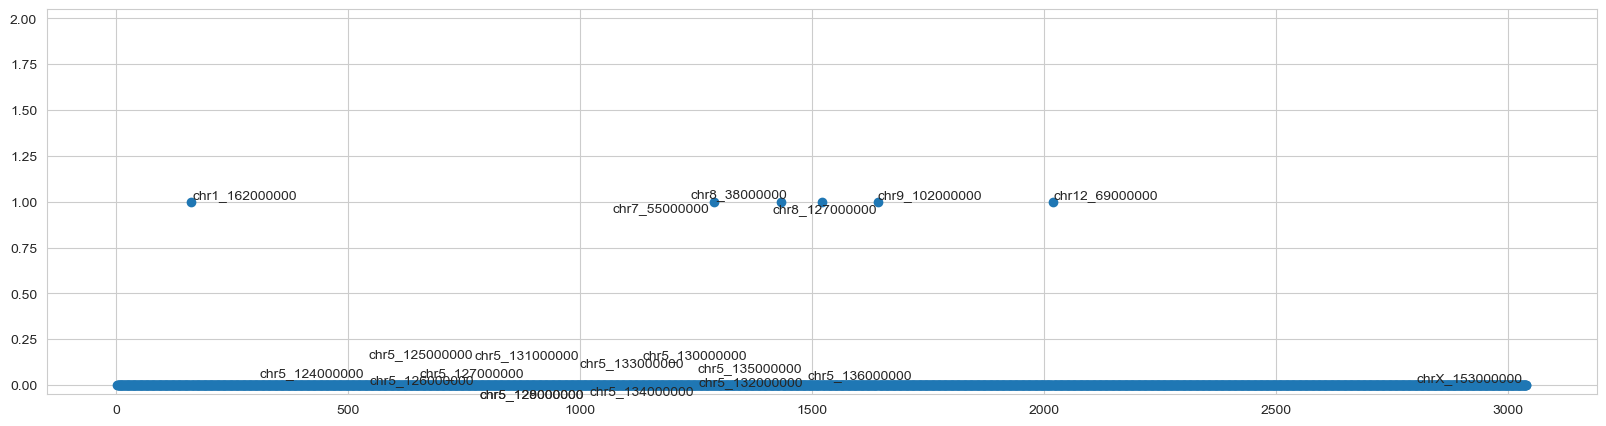

In [25]:
plt.figure(figsize=(20, 5))

plt.scatter(test_predictions['coord'], test_predictions['prediction'])

top_indices = test_predictions['prediction'].argsort()[-20:]

texts = []
for i in top_indices:
    x_value = test_predictions['loc'][i]
    texts.append(plt.text(i, test_predictions['prediction'][i], f'{x_value}', ha='center', va='bottom'))

adjust_text(texts)

plt.ylim(-0.05, 2.05)
plt.show()

In [26]:
matrix_test = read_mtx("data/raw/LC676/LC676_merged_hg38.sc_AAAGATGGTCCTCAGG/matrix.mtx", chr_index)
test_tensor, centers = slide(torch.from_numpy(matrix_test), window_0, window_1)

model.eval()
with torch.no_grad():
    test_tensor = test_tensor.unsqueeze(1).float().to("mps")

    test_pred = torch.argmax(model(test_tensor, centers), dim=1).to("cpu").numpy()

test_predictions = pd.DataFrame({"coord": centers, "prediction": test_pred})

test_predictions = pd.merge(test_predictions, chr_index, left_on="coord", right_on="index", how="left").drop("index",
                                                                                                             axis=1)

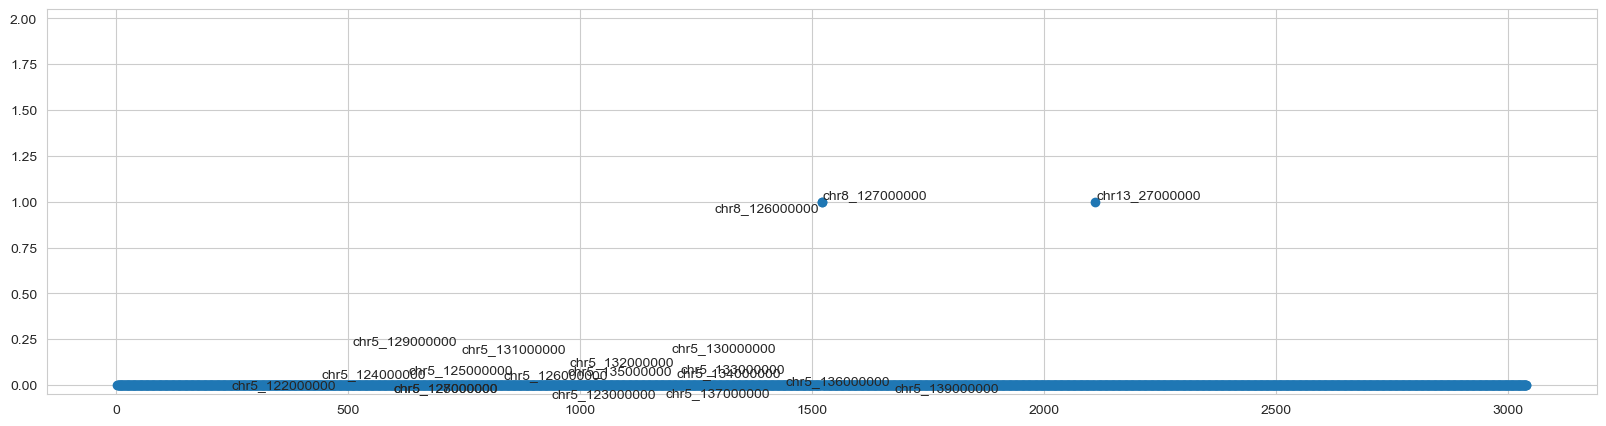

In [27]:
plt.figure(figsize=(20, 5))

plt.scatter(test_predictions['coord'], test_predictions['prediction'])

top_indices = test_predictions['prediction'].argsort()[-20:]

texts = []
for i in top_indices:
    x_value = test_predictions['loc'][i]
    texts.append(plt.text(i, test_predictions['prediction'][i], f'{x_value}', ha='center', va='bottom'))

adjust_text(texts)

plt.ylim(-0.05, 2.05)
plt.show()

In [28]:
matrix_test = read_mtx("data/raw/LC677/LC677_merged_hg38.sc_ACCGCAGGTAGATGAT/matrix.mtx", chr_index)
test_tensor, centers = slide(torch.from_numpy(matrix_test), window_0, window_1)

model.eval()
with torch.no_grad():
    test_tensor = test_tensor.unsqueeze(1).float().to("mps")

    test_pred = torch.argmax(model(test_tensor, centers), dim=1).to("cpu").numpy()

test_predictions = pd.DataFrame({"coord": centers, "prediction": test_pred})

test_predictions = pd.merge(test_predictions, chr_index, left_on="coord", right_on="index", how="left").drop("index",
                                                                                                             axis=1)

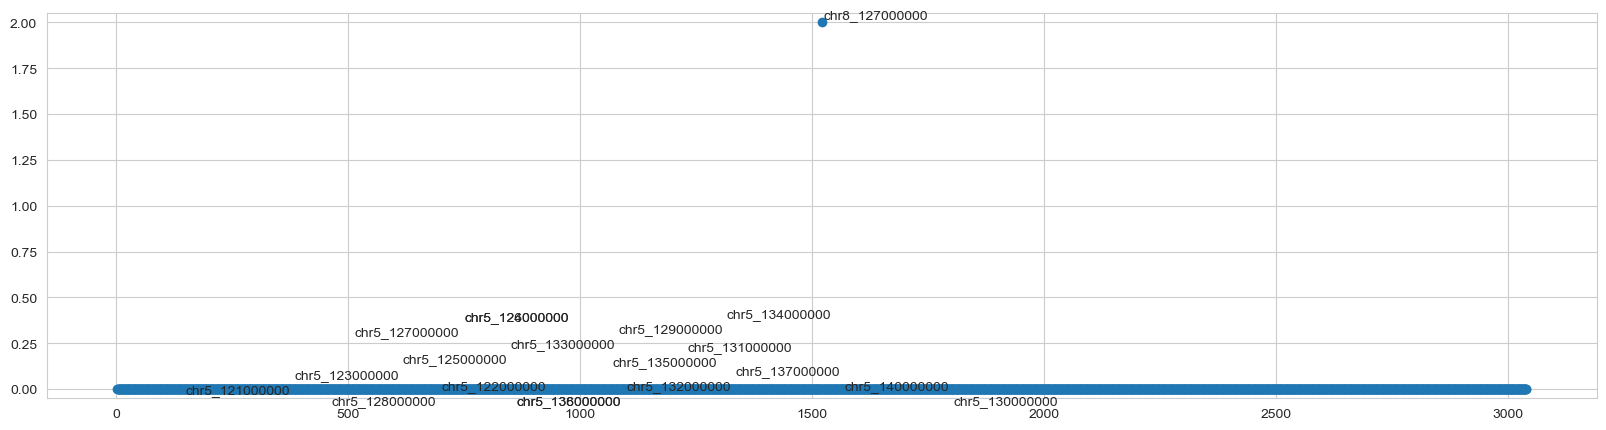

In [29]:
plt.figure(figsize=(20, 5))

plt.scatter(test_predictions['coord'], test_predictions['prediction'])

top_indices = test_predictions['prediction'].argsort()[-20:]

texts = []
for i in top_indices:
    x_value = test_predictions['loc'][i]
    texts.append(plt.text(i, test_predictions['prediction'][i], f'{x_value}', ha='center', va='bottom'))

adjust_text(texts)

plt.ylim(-0.05, 2.05)
plt.show()

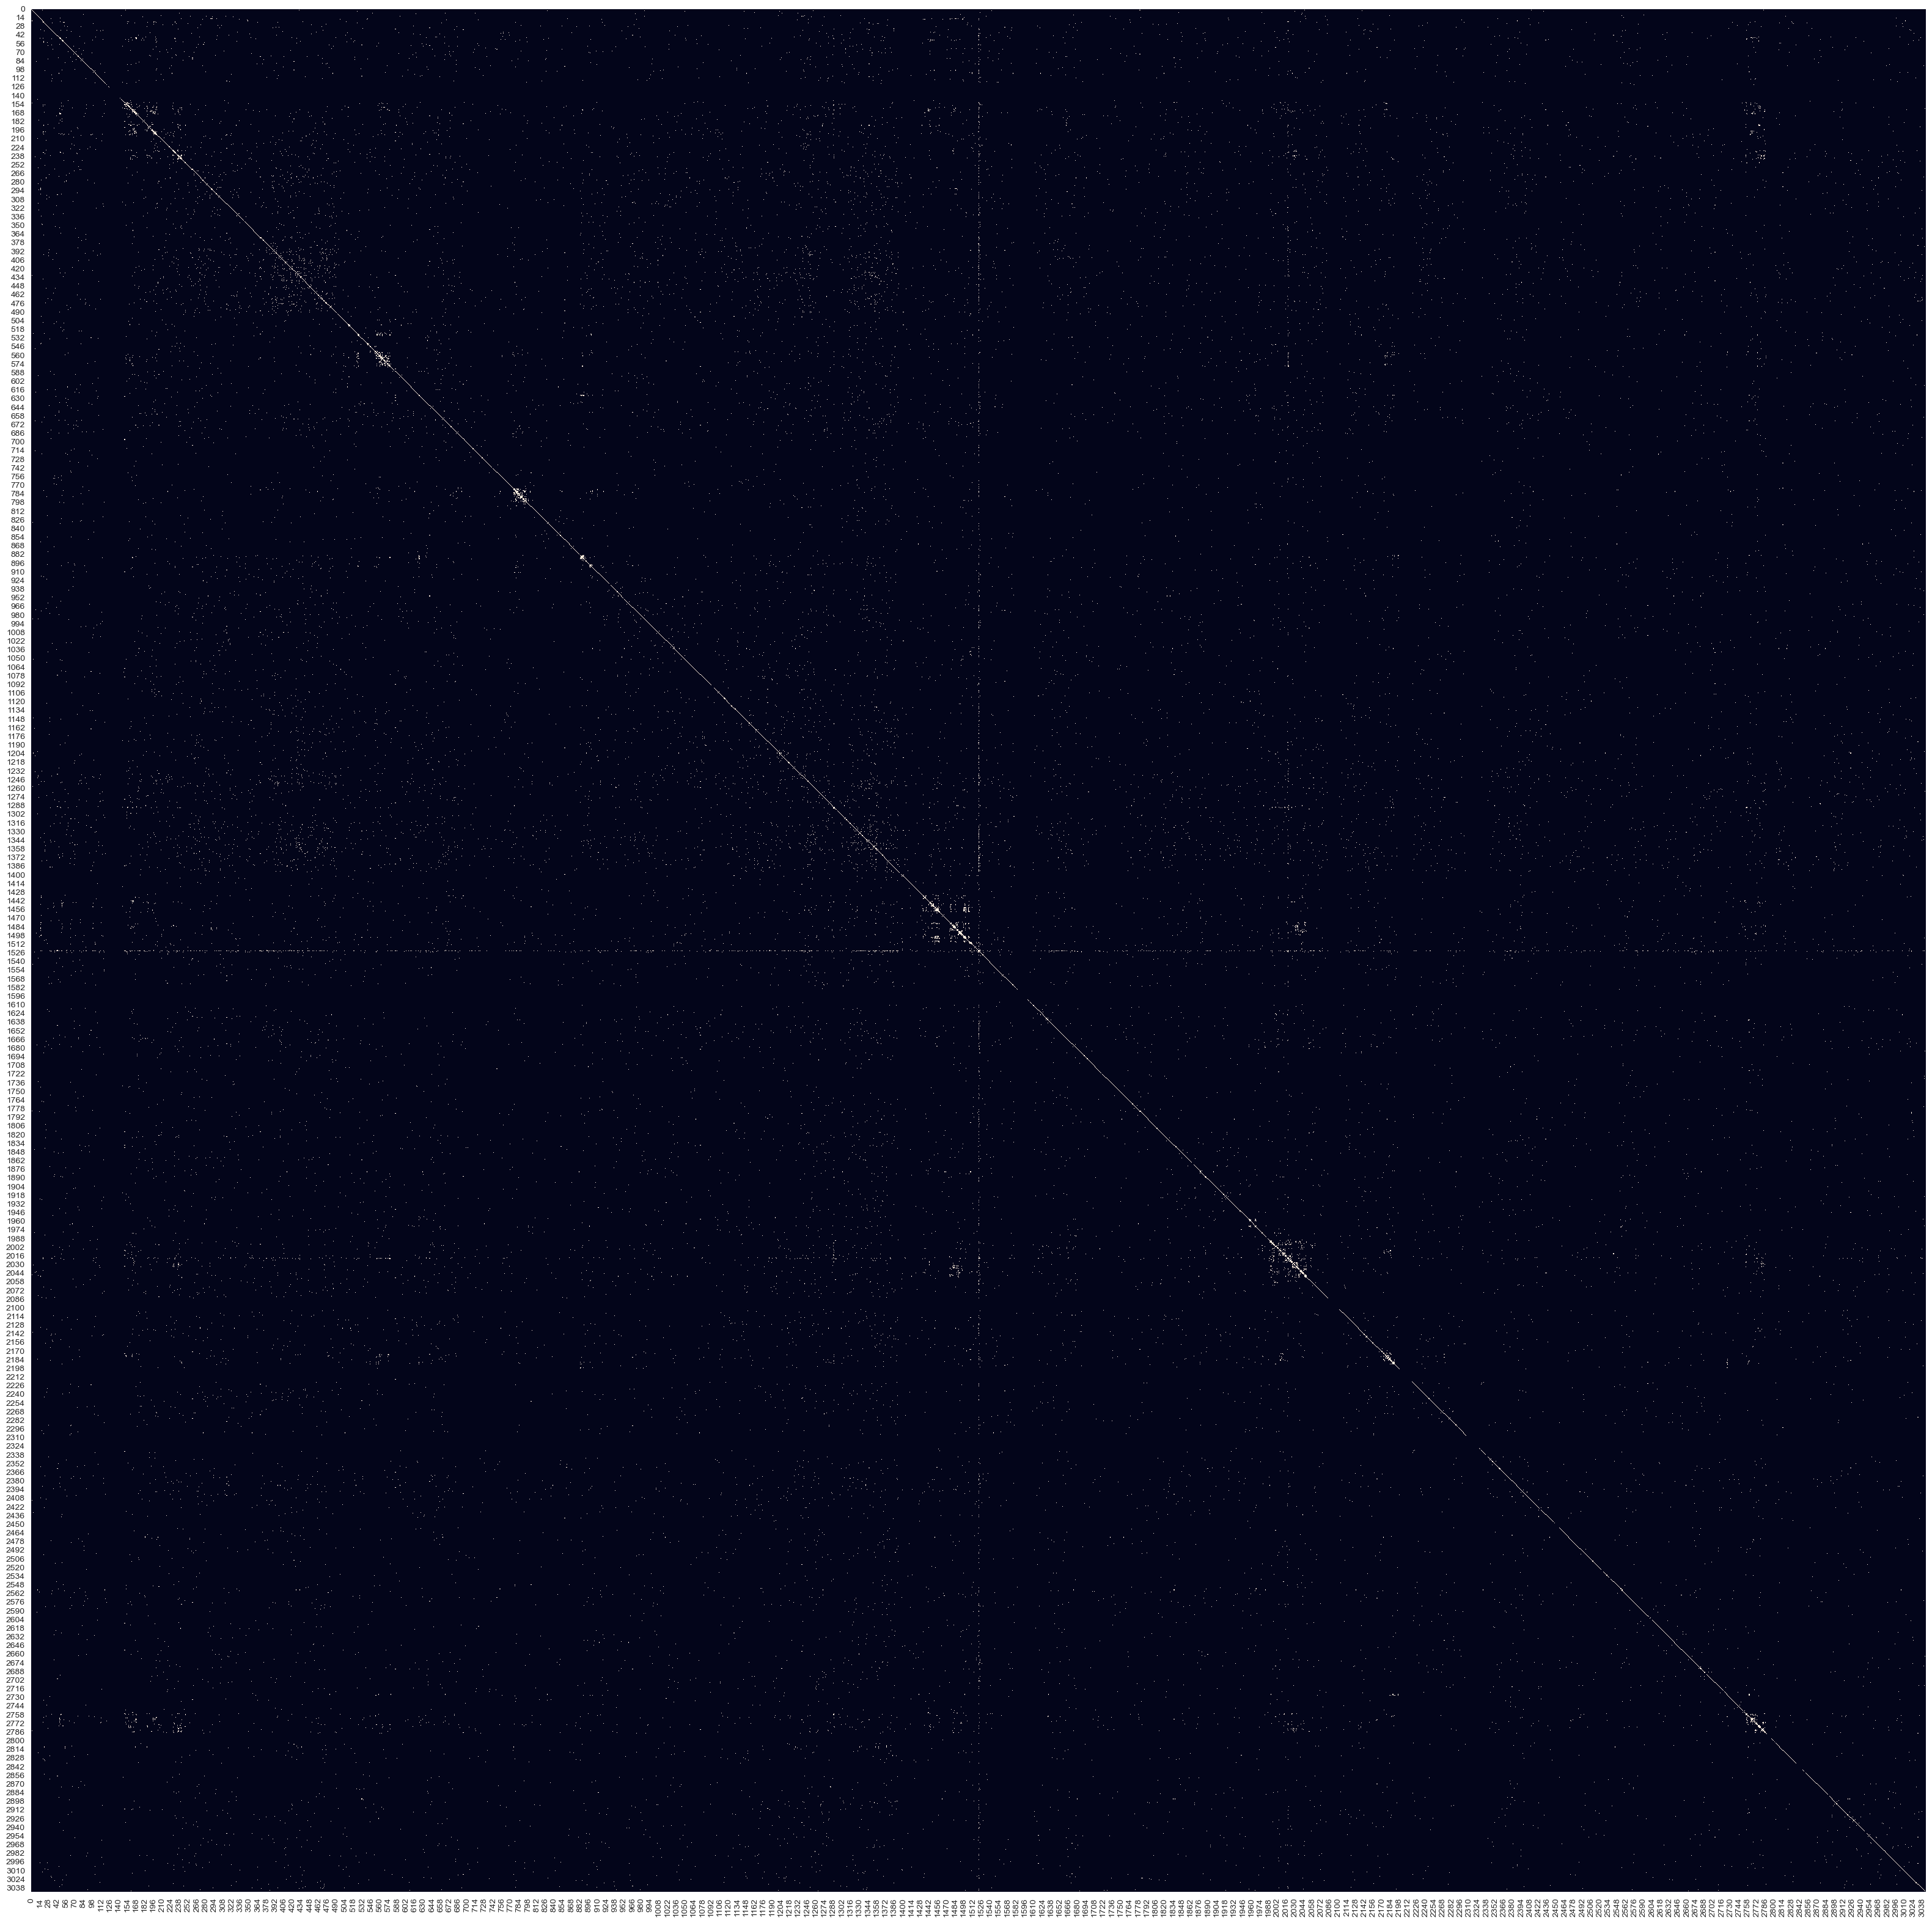

In [30]:
matrix_test = read_mtx("data/raw/LC500/LC500_ACTAGGTGTTACCCAA/matrix.mtx", chr_index)

plt.figure(figsize=(40, 40))
plot = sns.heatmap(matrix_test > 0, cbar=False)

plt.show()

In [31]:
#torch.save(model.state_dict(), "/Users/jiachensun/Library/CloudStorage/OneDrive-CaseWesternReserveUniversity/Chromatin/ecDNAFinder/model_jan10_2_multi.pt")

In [17]:
#model.load_state_dict(torch.load("/Users/jiachensun/Library/CloudStorage/OneDrive-CaseWesternReserveUniversity/Chromatin/ecDNAFinder/model_jan10_1_multi.pt"))

<All keys matched successfully>

In [18]:
val_labels = []
val_predictions = []
val_directories = []

model.eval()
with torch.no_grad():
        for x2, y0, bcs, coord in val_dataloader:
            x2 = x2.float().to("mps")
            y0 = y0.float().to("mps")

            yh = model(x2, coord)

            loss = criterion(yh, y0)
            
            yp_am = torch.argmax(yh, dim=1).to("cpu").numpy().tolist()
            y0_am = torch.argmax(y0, dim=1).to("cpu").numpy().tolist()

            val_labels = val_labels + y0_am
            val_predictions = val_predictions + yp_am
            val_directories = val_directories + list(bcs)

        pred_summary = pd.DataFrame(
            {"label": val_labels, "prediction": val_predictions, "barcode": val_directories})
        pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

        conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
        tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

In [19]:
conf_matrix

array([[561,   2],
       [ 77, 233]])